In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import pandas as pd
import pickle
import numpy as np # python math library for matrix operation
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

# Loading Path

In [ ]:
images_dir = os.listdir("/content/drive/MyDrive/Project/Image_Caption_Project/Flicker8k_Dataset") 

In [ ]:
images_path = '/content/drive/MyDrive/Project/Image_Caption_Project/Flicker8k_Dataset'
captions_path = '/content/drive/MyDrive/Project/Image_Caption_Project/Flickr8k_text/Flickr8k.token.txt'
train_path = '/content/drive/MyDrive/Project/Image_Caption_Project/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = '/content/drive/MyDrive/Project/Image_Caption_Project/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = '/content/drive/MyDrive/Project/Image_Caption_Project/Flickr8k_text/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
len(x_train)

6001

In [ ]:
print(len(captions))
captions[:3]

40461


['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .']

# storing captions into dictionary named "tokens"

In [ ]:
tokens = {}  #empty dictionary

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

In [ ]:
tokens

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

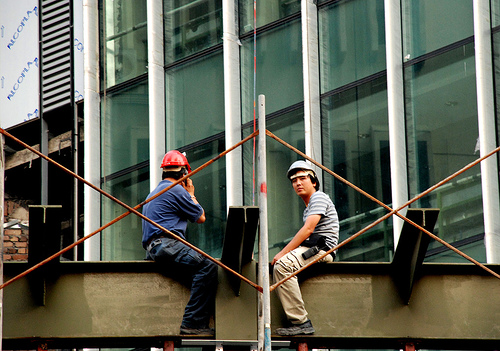

Two constructions workers sit on a beam taking a break .
Two construction workers are sitting up on the side of a building .
Two construction workers sitting on an I-beam .
Two construction workers take a seat on a steel beam .
Two men take a break from construction .


In [ ]:
temp = captions[200].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+"/"+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

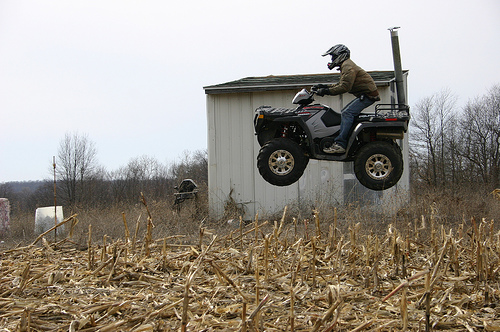

A man jumps gin the air while riding an ATV
A man on a four-wheeler jumps near a small building .
An ATV is airborne over a field in front of a white structure .
A person dressed in a tan jacket jumps a quad over a harvested cornfield in front of a small out building .
Man on four wheeler in the air .


In [ ]:
from IPython.display import Image, display
temp = captions[467].split("#")
z = Image(filename=images_path+"/"+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

# Creating List of images and captions

In [ ]:
x_imgs=[]
captions=[]
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        x_imgs.append(img)
        captions.append(caption)

## Saving list of images and captions into dataframe

In [ ]:
data={'images':x_imgs,'captions':captions}
df=pd.DataFrame(data)
df.head()

,images,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


# Processing on the captions

In [ ]:
words = [i.split() for i in captions]
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))
print(len(unique))
vocab_size = len(unique)

8253


In [ ]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [ ]:
word_2_indices['GF'] = 0
indices_2_word[0] = 'GF'

In [ ]:
with open( "w2i.p", "wb" ) as pickle_f:
    pickle.dump(word_2_indices, pickle_f )
with open( "i2w.p", "wb" ) as pickle_f:
    pickle.dump(indices_2_word, pickle_f )

In [ ]:
with open('/content/w2i.p', 'rb') as f:
    word_2_indices= pickle.load(f, encoding="bytes")
with open('/content/i2w.p', 'rb') as f:
    indices_2_word= pickle.load(f, encoding="bytes")

In [ ]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [ ]:
max_len = 0
for i in captions:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [ ]:
padded_sequences, subsequent_words = [], []
for ix in tqdm(range(len(captions))):
    partial_seqs = []
    next_words = []
    text = captions[ix].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')
    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

  0%|          | 0/30000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 30000/30000 [00:04<00:00, 6388.15it/s]


# Loading ResNet Model

In [ ]:
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

94781440/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

# Processing on Images

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
imgs={}
for i in tqdm(x_train[:6000]):
    if i in imgs.keys():
        continue
    path = images_path + "/"+ i
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    imgs[i]=pred

100%|██████████| 6000/6000 [1:14:33<00:00,  1.34it/s]


In [ ]:
len(imgs)

6000

In [ ]:
with open( "proces_imgs.p", "wb" ) as pickle_f:
    pickle.dump(imgs, pickle_f )

In [ ]:
with open('/content/proces_imgs.p', 'rb') as f:
    imgs= pickle.load(f, encoding="bytes")

In [ ]:
img = []
for i in tqdm(range(df.shape[0])):
    if df.iloc[i, 0] in imgs.keys():
        img.append(imgs[df.iloc[i, 0]])

img = np.asarray(img)
print(img.shape)

100%|██████████| 30000/30000 [00:02<00:00, 12804.24it/s]


(30000, 2048)


# Creating NN Layers for images and captions( CNN and LSTM) and concatening them

In [ ]:

embedding_size = 128
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          32896     
 ibuted)                                                         
                                                                 
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

In [ ]:

def tr_gen(inp,ne_words,batch_size=256):
    cap=inp[1]
    imgs=inp[0]
    while True:
        for i in range(0,30000-batch_size,batch_size):
            n_words=[]
            i_cap=[]
            im=[]
            for j in range(batch_size):
                n_words.extend(ne_words[i+j].tolist())
                i_cap.extend(cap[i+j].tolist())
            for ix in range(i,i+batch_size):
                for iy in range(cap[ix].shape[0]):
                    im.append(imgs[ix])
                
            i_cap=np.array(i_cap)
            n_words=np.asarray(n_words)
            im= np.asarray(im)
        
            yield [im,i_cap],n_words

In [ ]:
train_gen=tr_gen([img,padded_sequences],subsequent_words,batch_size=256)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_acc.h5', monitor = 'accuracy' , mode = 'max', verbose = 1 , save_best_only = True)

# Fitting the model

In [ ]:
hist=model.fit_generator(train_gen,steps_per_epoch=30000//256,callbacks = [mc],epochs=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
117/117 [==============================] - ETA: 0s - loss: 5.3702 - accuracy: 0.1071
Epoch 1: accuracy improved from -inf to 0.10705, saving model to best_model_acc.h5
117/117 [==============================] - 302s 3s/step - loss: 5.3702 - accuracy: 0.1071
Epoch 2/20
117/117 [==============================] - ETA: 0s - loss: 4.8873 - accuracy: 0.1798
Epoch 2: accuracy improved from 0.10705 to 0.17982, saving model to best_model_acc.h5
117/117 [==============================] - 295s 3s/step - loss: 4.8873 - accuracy: 0.1798
Epoch 3/20
117/117 [==============================] - ETA: 0s - loss: 4.5682 - accuracy: 0.2348
Epoch 3: accuracy improved from 0.17982 to 0.23483, saving model to best_model_acc.h5
117/117 [==============================] - 295s 3s/step - loss: 4.5682 - accuracy: 0.2348
Epoch 4/20
117/117 [==============================] - ETA: 0s - loss: 4.4110 - accuracy: 0.2542
Epoch 4: accuracy improved from 0.23483 to 0.25420, saving model to best_model_acc.h5
117/1

In [ ]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [ ]:
l=os.listdir('/content/drive/MyDrive/Project/Image_Caption_Project/Flicker8k_Dataset')
l[:2]

['3264464625_c711cc40c6.jpg', '1542033433_5453d4c466.jpg']

In [ ]:
img = '/content/drive/MyDrive/Project/Image_Caption_Project/Flicker8k_Dataset/'+l[4681]
#img='../input/backgrd-sample-imgs/2019-02-10-13-40-01-855.jpg'
test_img = get_encoding(resnet, img)

# Prediction

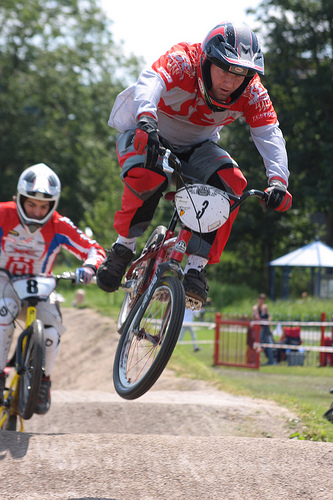

A man in a helmet is riding a motorcycle .


In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)
z = Image(filename=img)
display(z)

print(Argmax_Search)